In [219]:
"""
Generates synthetic weather time series data for training and testing our model.
"""

import random
import pandas as pd
from tqdm import tqdm 
import numpy as np
from enum import Enum
from dateutil.relativedelta import relativedelta

class Weather(Enum):
    # Weather values ENUM
    SUNNY = 1
    RAINY = 2
    CLOUDY = 3
    SNOW = 4

    @classmethod
    def weatherProb(self, temp):
        if temp < 35:
            return [0.33,0,0.33,0.34]
        if temp < 60:
            return [0.3,0.4,0.3,0]
        if temp < 80:
            return [0.4, 0.2, 0.4, 0]
        return [0.7, 0.05, 0.25, 0]
                
                
class GenTemperature(object):
    # Generate Temperature Data
    def __init__(self, groups=1, days=10000, var = 5,):
        self.groups = groups # time series groups
        self.days = days
        self.samples = self.groups*self.days
        self.date_range = pd.date_range(start="1980-01-01", periods=self.days, freq='D')
        self.var = var

    def generate(self):
        # generate dates
        df = pd.DataFrame(self.date_range, columns=["timestamp"])
        df = pd.concat([df]*self.groups, ignore_index=False)
        df["index"] = range(df.shape[0]) 
        df["group"] = pd.cut(df['index'], bins=self.groups, labels=range(0,self.groups), include_lowest=True)
        temp_df = df.groupby("group")
        df["t_index"] = temp_df.cumcount() + 1
        
        # generate brownian motion 
        df["base"] = self.__genBrownian(var=self.var)
        print("final:", self.date_range[-1])
        print("og:", self.date_range[0])
        years = (self.date_range[-1] - self.date_range[0]) / np.timedelta64(1,'Y') 
        print("Years:",years)
        observ_per_year = self.days / years
        print("Year IDX:", observ_per_year)

        year_noise = lambda x : np.random.uniform(int(x*self.samples+1)%observ_per_year / observ_per_year )
        df["temperature"] = df["base"].apply(lambda x : 
                                     50 + 46*np.cos(2*np.pi * x / observ_per_year) + np.random.uniform(-7,7))
        #shift = np.random.uniform(-14,10)
        #scale = np.random.uniform(0.8,1.1)
        #df["temperature"] = df["temperature"].apply(lambda x : scale*x + shift)
                                                    
        df["weather"] = df["temperature"].apply(lambda x: 
                                        np.random.choice(["SUNNY","RAINY", "CLOUDY","SNOW"],p=Weather.weatherProb(x) ) )
        #df = df.drop("index",axis=1).drop("base",axis=1)
        return df
    
                                                         
    def __genBrownian(self,var=0.01):
        steps = np.random.normal(loc=0.0, scale=np.sqrt(var),size=self.samples)
        result = np.cumsum(steps)
        return result + np.linspace(0,self.samples,self.samples)

In [243]:
gt = GenTemperature(groups=2, days=365, var=18)

In [244]:
df = gt.generate()

final: 1980-01-03 00:00:00
og: 1980-01-01 00:00:00
Years: 0.005475814013977016
Year IDX: 547.86375


In [245]:
df.head(10)

,timestamp,index,group,t_index,base,temperature,weather
0,1980-01-01,0,0,1,-2.352827,100.183434,RAINY
1,1980-01-02,1,0,2,-1.279186,95.028300,RAINY
2,1980-01-03,2,0,3,0.748862,101.987204,SUNNY
0,1980-01-01,3,1,1,0.286675,98.124441,SUNNY
1,1980-01-02,4,1,2,6.588286,101.762485,CLOUDY
2,1980-01-03,5,1,3,1.436408,93.249621,RAINY


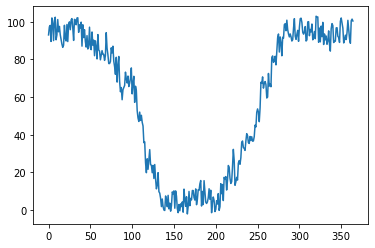

In [242]:
import matplotlib.pyplot as plt
plt.plot(df[df['group']==0].index.values,df[df['group'] == 0]["temperature"])
plt.show()